In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import sasc.viz
from sasc.config import FMRI_DIR, RESULTS_DIR
import dvu
import sasc.viz
dvu.set_style()

### Barplots

In [ ]:
# default
uts01 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot4_default_means.pkl'))
uts02 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot_default_means.pkl'))
uts03 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot3_default_means.pkl'))
# sasc.viz.barplot_default([uts01['diag_means'], uts02['diag_means'], uts03['diag_means']],
#                          [uts01['off_diag_means'], uts02['off_diag_means'],
#                              uts03['off_diag_means']],
#                          pilot_name='full_', expls=[], annot_points=False, spread=80)

# interactions
uts01 = joblib.load(join(RESULTS_DIR, 'processed',
                    'pilot4_interactions_means.pkl'))
uts02 = joblib.load(join(RESULTS_DIR, 'processed',
                    'pilot2_interactions_means.pkl'))
uts03 = joblib.load(join(RESULTS_DIR, 'processed',
                    'pilot3_interactions_means.pkl'))
# sasc.viz.barplot_interaction([uts01['diag_means'], uts02['diag_means'], uts03['diag_means']],
#                              [uts01['off_diag_means'], uts02['off_diag_means'],
#                                  uts03['off_diag_means']],
#                              [uts01['diag_means_interaction'], uts02['diag_means_interaction'],
#                               uts03['diag_means_interaction']],
#                              [uts01['off_diag_means_interaction'], uts02['off_diag_means_interaction'],
#                               uts03['off_diag_means_interaction']],
#                              pilot_name='full_')


def barplot_default_no_baseline():
    d = defaultdict(list)
    for subj, fname in zip(['S01', 'S02', 'S03'],
                           ['pilot4_default_means.pkl', 'pilot_default_means.pkl', 'pilot3_default_means.pkl']):
        data = joblib.load(join(RESULTS_DIR, 'processed', fname))
        n = len(data['diag_means'])
        assert n == len(data['off_diag_means'])
        for i in range(n):
            d['subj'].append(subj)
            d['diag'].append(data['diag_means'][i])
            d['off_diag'].append(data['off_diag_means'][i])

    plt.figure(figsize=(4.5, 3))
    sns.set_context("notebook", rc={"lines.markeredgewidth": 2})
    df = pd.DataFrame(d)
    df['diff'] = df['diag'] - df['off_diag']
    np.random.seed(1)
    sns.stripplot(data=df, x='subj',
                  y='diff', s=6, palette='dark:C0', alpha=0.6, hue='subj', jitter=0.3,)

    plt.bar(1, df['diff'].mean(), yerr=df['diff'].std() / np.sqrt(len(df)),
            width=2.5, color='C0', alpha=0, capsize=4, error_kw={'elinewidth': 2}, zorder=100000)  # , fmt='o')
    plt.bar(1, df['diff'].mean(), yerr=df['diff'].std() / np.sqrt(len(df)),
            width=2.5, color='C0', alpha=0.2, capsize=4, error_kw={'elinewidth': 2}, zorder=-100000)  # , fmt='o')

    # plt.plot([-0.25, 2.25], [0, 0], color='gray', linestyle='--', lw=3)
    plt.axhline(0, color='gray', linestyle='--', lw=3, alpha=0.5)
    # plt.text(3, 0, 'Baseline', color='gray',
    #  va='center', ha='right', fontsize='small')
    plt.xlabel('Subject')
    plt.ylabel('Mean driving\nvoxel response ($\sigma_f$)')
    plt.tight_layout()
    plt.savefig(join(RESULTS_DIR, 'figs', 'main',
                'full_default_means_updated.pdf'))


def barplot_interaction_no_baseline():
    d = defaultdict(list)
    for subj, fname in zip(['S01', 'S02', 'S03'],
                           ['pilot4_interactions_means.pkl', 'pilot2_interactions_means.pkl', 'pilot3_interactions_means.pkl']):
        data = joblib.load(join(RESULTS_DIR, 'processed', fname))
        n = len(data['diag_means'])
        assert n == len(data['off_diag_means'])
        for i in range(n):
            d['subj'].append(subj)
            d['diag'].append(data['diag_means'][i])
            d['off_diag'].append(data['off_diag_means'][i])
            d['setting'].append('single')
        n2 = len(data['diag_means_interaction'])
        assert n2 == len(data['off_diag_means_interaction'])
        for i in range(n2):
            d['subj'].append(subj)
            d['diag'].append(data['diag_means_interaction'][i])
            d['off_diag'].append(data['off_diag_means_interaction'][i])
            d['setting'].append('pair')

    plt.figure(figsize=(4.5, 3))
    sns.set_context("notebook", rc={"lines.markeredgewidth": 2})
    df = pd.DataFrame(d)
    df['diff'] = df['diag'] - df['off_diag']
    np.random.seed(11)
    df = df.sort_values(by='subj')
    df['x'] = df['subj'] + df['setting']
    colors = ['C0', '#5D3F6A']
    for i, setting in enumerate(['single', 'pair']):
        d = df[df['setting'] == setting]
        plt.bar([1, 4][i], d['diff'].mean(), yerr=d['diff'].std() / np.sqrt(len(d)),
                width=2.75, color=colors[i], alpha=0.2, capsize=4, error_kw={'elinewidth': 2}, zorder=100000)

    # sns.swarmplot(
    #     data=df, x='x', hue='subj',
    #     order=['S01single', 'S02single', 'S03single',
    #                'S01pair', 'S02pair', 'S03pair', ],
    #     y='diff', s=6, palette='dark:C0', alpha=0.6)  # , jitter=0.3,)
    # replot above but with different marker for each 'x'
    markers = ['o', 'X', '^']
    colors = ['C0', '#5D3F6A']
    for i, x in enumerate(['S01single', 'S02single', 'S03single', 'S01pair', 'S02pair', 'S03pair']):
        d = df[df['x'] == x]
        sns.swarmplot(data=d, x='x', hue='subj', y='diff', s=6,
                      #   color=colors[i//3],
                      palette=[colors[i//3]],
                      alpha=0.8, marker=markers[i % 3], legend=False)

    plt.xlabel('')
    plt.ylabel('Mean driving\nvoxel response ($\sigma_f$)')

    # plt.plot([-0.5, 1.5], [0, 0], color='gray', linestyle='--')
    plt.axhline(0, color='gray', linestyle='--', lw=3, alpha=0.5)
    plt.xticks([1, 4], ['Single', 'Pair'])
    # plt.text(1.5, 0, 'Baseline', color='gray',
    #  va='center', ha='right', fontsize='small')

    # move legend to the right
    # plt.legend(title='Subject', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(join(RESULTS_DIR, 'figs', 'main',
                'full_interaction_means_updated.pdf'), bbox_inches='tight')
    return df


barplot_default_no_baseline()
df = barplot_interaction_no_baseline()

In [ ]:


# polysemantic
uts02 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot2_poly_means.pkl'))
uts03 = joblib.load(join(RESULTS_DIR, 'processed', 'pilot3_poly_means.pkl'))
sasc.viz.barplot_polysemantic([uts02['diag_means'], uts03['diag_means']],
                              [uts02['off_diag_means'], uts03['off_diag_means']],
                              pilot_name='full_', expls=[], annot_points=False)

### Stability scores

In [115]:
encoding_scores = joblib.load(join(RESULTS_DIR,
                                   'processed', 'encoding_scores.pkl'))
voxel_scores_files = {
    'uts01': 'pilot4_default_voxel_scores.pkl',
    'uts02': 'pilot_default_voxel_scores.pkl',
    'uts03': 'pilot3_default_voxel_scores.pkl'
}
voxel_scores = []
for subj, fname in voxel_scores_files.items():
    scores_drive = joblib.load(join(RESULTS_DIR, 'processed', fname))
    scores_drive = scores_drive.merge(
        encoding_scores[encoding_scores.subject == subj][['module_num', 'encoding_score']], on='module_num')
    voxel_scores.append(scores_drive)


def plot_line_with_corr(
        voxel_scores, i=0, cs=['C0', '#5D3F6A', 'mediumseagreen'],
        markers=['o', 'o', 'o'], yoffset=0, plot_key='stability_score'):

    x = voxel_scores[plot_key].values
    y = voxel_scores["driving_score"].values
    plt.plot(x, y, markers[i], color=cs[i], markersize=7, alpha=0.8)

    # plot line of best fit
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color=cs[i], alpha=0.5, markersize=0.5)

    # add annotation
    subjs = ['S02', 'S03', 'S01']
    corr = np.corrcoef(x, y)[0, 1]
    xend = max(x) + 0.01
    yend = m * xend + b + 0.01
    plt.text(
        xend,
        yend + yoffset,
        f"{subjs[i]}, $\\rho$={corr:.2f}",
        color=cs[i],
        fontsize='small'
    )

    plt.ylabel("Driving score")
    if plot_key == 'stability_score':
        plt.xlabel("Stability score")
    elif plot_key == 'encoding_score':
        plt.xlabel("Encoding drive score")

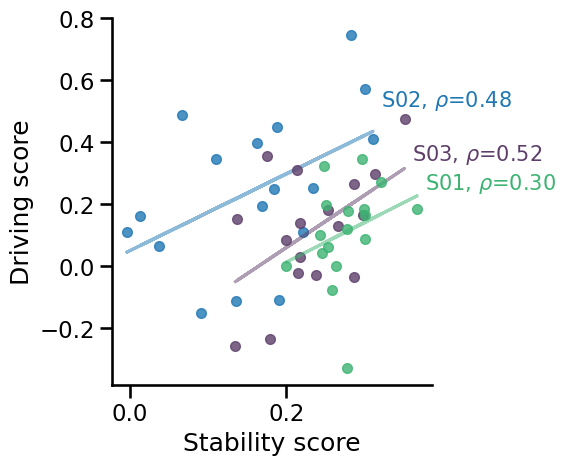

In [117]:
plt.figure(figsize=(6, 5))
sns.set_context("talk", rc={"lines.markeredgewidth": 2})
plot_line_with_corr(voxel_scores[1], i=0, yoffset=0.06)
plot_line_with_corr(voxel_scores[0], i=1)
plot_line_with_corr(voxel_scores[2], i=2)


plt.savefig(join(RESULTS_DIR, 'figs/misc',
            'full_stability_score.pdf'), bbox_inches='tight')
plt.show()

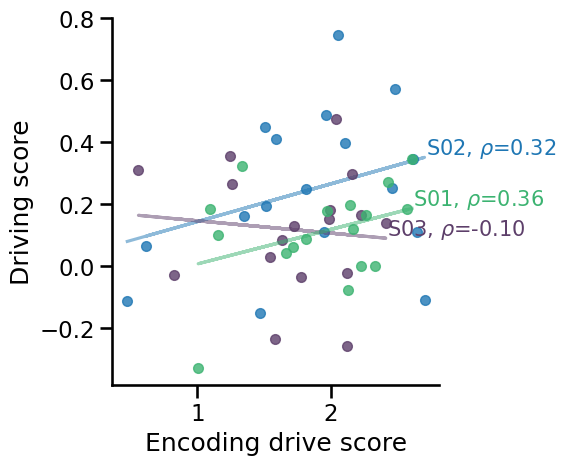

In [119]:
plt.figure(figsize=(6, 5))
sns.set_context("talk", rc={"lines.markeredgewidth": 2})
plot_line_with_corr(voxel_scores[1], i=0, plot_key='encoding_score')
plot_line_with_corr(voxel_scores[0], i=1, plot_key='encoding_score')
plot_line_with_corr(voxel_scores[2], i=2, plot_key='encoding_score')


plt.savefig(join(RESULTS_DIR, 'figs/misc',
            'full_stability_score.pdf'), bbox_inches='tight')
plt.show()

### Example curve with predictions

In [ ]:
pred, actual = joblib.load(join(sasc.config.RESULTS_DIR,
                                'processed', 'vox23367_pred_actual.jbl'))

plt.figure(figsize=(4, 2.5))
plt.plot(actual[:80], '-', color='gray', lw=3)
plt.plot(pred[:80], '-', color='C0', lw=3)
# plt.axhline(0, color='gray', linestyle='--', lw=3)
# plt.axhline(np.mean(resps_rep_means[5]), color='#08b47c', linestyle='--', lw=3)
plt.ylim(-2, 2)
plt.xticks([])
plt.yticks([])

print('corr', np.corrcoef(pred, actual)[0, 1])
# turn on all splines
for spine in plt.gca().spines.values():
    spine.set_visible(True)

    # make spline thick
    spine.set_linewidth(3)
plt.savefig(join(sasc.config.RESULTS_DIR, 'figs',
            'misc', 'food_prep_pred_resp.pdf'), bbox_inches='tight')

### Create dummy legend

In [ ]:
# create a dummy legend with a gray circle and triangle
# to represent the two subjects
plt.figure(figsize=(3, 1))
plt.plot([], [], 'o', color='gray', label='S01', markersize=15)
plt.plot([], [], 'X', color='gray', label='S02', markersize=15)
plt.plot([], [], '^', color='gray', label='S03',
         markersize=15, markeredgewidth=4)
plt.legend(loc='center', ncol=3, frameon=True, fontsize='large')
plt.axis('off')
plt.savefig(join(RESULTS_DIR, 'figs/misc',
            'full_stability_score_legend.pdf'), bbox_inches='tight')

### Story scores

In [ ]:
default02 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot_default_story_scores.pkl'))
default03 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot3_default_story_scores.pkl'))
interactions02 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot2_interactions_story_scores.pkl'))
interactions03 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot3_interactions_story_scores.pkl'))
polysemantic02 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot2_poly_story_scores.pkl'))
polysemantic03 = joblib.load(
    join(RESULTS_DIR, 'processed', 'pilot3_poly_story_scores.pkl'))


dfs = [default02, default03, interactions02,
       interactions03, polysemantic02, polysemantic03]
subj = ['S2', 'S3', 'S2', 'S3', 'S2', 'S3']
setting = ['Single-voxel', 'Single-voxel', 'Interaction', 'Interaction',
           'Polysemantic', 'Polysemantic']
df_big = []
for df in dfs:
    # make barplot comparing driving and baseline
    d = df.melt(id_vars='story', value_vars=[
        'driving', 'baseline'], var_name='condition', value_name='mean')
    d['subj'] = subj.pop(0)
    d['setting'] = setting.pop(0)
    d['story'] = d.apply(lambda x: x['subj'] + ' ' + x['story'], axis=1)
    df_big.append(deepcopy(d))

df_big = pd.concat(df_big)
df_big['story'] = df_big['story'].str.replace('GenStory', '')
df_big = df_big[df_big['condition'] == 'driving']


# set xticklabels rotated
plt.figure(figsize=(8, 5))
# plt.grid()

# shade bars by subj
offset = 0
xticklabels = []
for i, setting in enumerate(df_big['setting'].unique()):
    d = df_big[df_big['setting'] == setting]
    d = d.sort_values('story')
    plt.bar(np.arange(len(d)) + offset, d['mean'], label=setting,
            color=sns.color_palette("Blues", 3)[i])
    xticklabels += d['story'].tolist()
    offset += len(d)

# move legend to right
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2,
           borderaxespad=0., fontsize='x-small')

plt.xticks(rotation=90, va='top', labels=xticklabels,
           ticks=np.arange(len(xticklabels)))
plt.xlabel('Story')


plt.ylabel('Mean driving voxel response ($\sigma_f$)')
plt.savefig(join(RESULTS_DIR, 'figs/main', 'full_story_breakdown.pdf'))

plt.show()